# Preparation

In [1]:
import numpy as np
import pandas as pd
import ringity as rng
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import ringity.networks.geometric_networks as rgeom

from tqdm import tqdm
from pathlib import Path
from itertools import product, combinations
from collections import defaultdict
from scipy.spatial import distance, Delaunay
from sklearn.neighbors import kneighbors_graph
from ringity.tda.pdiagram.readwrite import json_to_dictofdictoflist, data_to_json

In [2]:
METRICS = ['spl', 'resistance', 'betweenness', 'current_flow']
PALETTE = sns.color_palette(n_colors = len(METRICS))
COLOR_X = sns.color_palette('dark', n_colors = 8)[-1]

DIRNAME_DATA = Path.cwd().parent / 'data'

In [3]:
def knn_cylinder(n, height,
                 seed = None,
                 **network_params):
    X = rgeom.point_clouds.cylinder(N = n, height = height, seed = seed)
    X += np.random.normal(scale = 2**(-10), size = X.shape)
    G = knn_graph(X, k)
    return G, X


def knn_graph(X, k):
    A = kneighbors_graph(X, k, mode = 'connectivity', include_self = False)
    B = A.tocoo()
    edges = [edge for edge in zip(B.row, B.col)]
    G = nx.Graph()
    G.add_edges_from(edges)
    return G

def update_data_dict(data_dict, 
                     network_generator,
                     network_params, 
                     sweep_val,
                     sweep_param,
                     point_cloud = False):
    while True:
        if point_cloud:
            G, X = network_generator(**network_params, 
                                     **{sweep_param : sweep_val})  
        else:
            G = network_generator(**network_params, 
                                  **{sweep_param : sweep_val})
        if nx.is_connected(G):
            break
    
    if point_cloud:
        pdgm_X = rng.pdiagram_from_point_cloud(X)
        data_dict['X'][sweep_val].append(pdgm_X.trimmed(25))

    for metric in METRICS:
        pdgm = rng.pdiagram_from_network(G, metric = metric)
        data_dict[metric][sweep_val].append(pdgm.trimmed(25))
        
        
def data_dict_to_scores_df(data_dict, 
                           key1_name = 'metric',
                           key2_name = 'sweep_param'):
    to_concatinate = []
    for key1, data in data_dict.items():
        for key2, pdgms in data.items():
            scores = list(map(rng.ring_score, pdgms))
            df_metric_chunk = pd.DataFrame({'scores' : scores,
                                            key1_name : key1,
                                            key2_name : key2})
            to_concatinate.append(df_metric_chunk)

    scores_df = pd.concat(to_concatinate, ignore_index = True)
    return scores_df

--- 

# Watts-Strogatz Example

## Set Network Parameters

In [4]:
# Network parameters
n = 1000
k = 10

sweep_param = 'p'
nb_sweep_vals = 2**5 + 1
min_sweep_val = 0
max_sweep_val = 1

network_generator = nx.watts_strogatz_graph
network_params = {'n' : n, 'k' : k}
fname_pdgms = DIRNAME_DATA / 'results' / f'pdgms-WS-N{n}_k{k}.json'

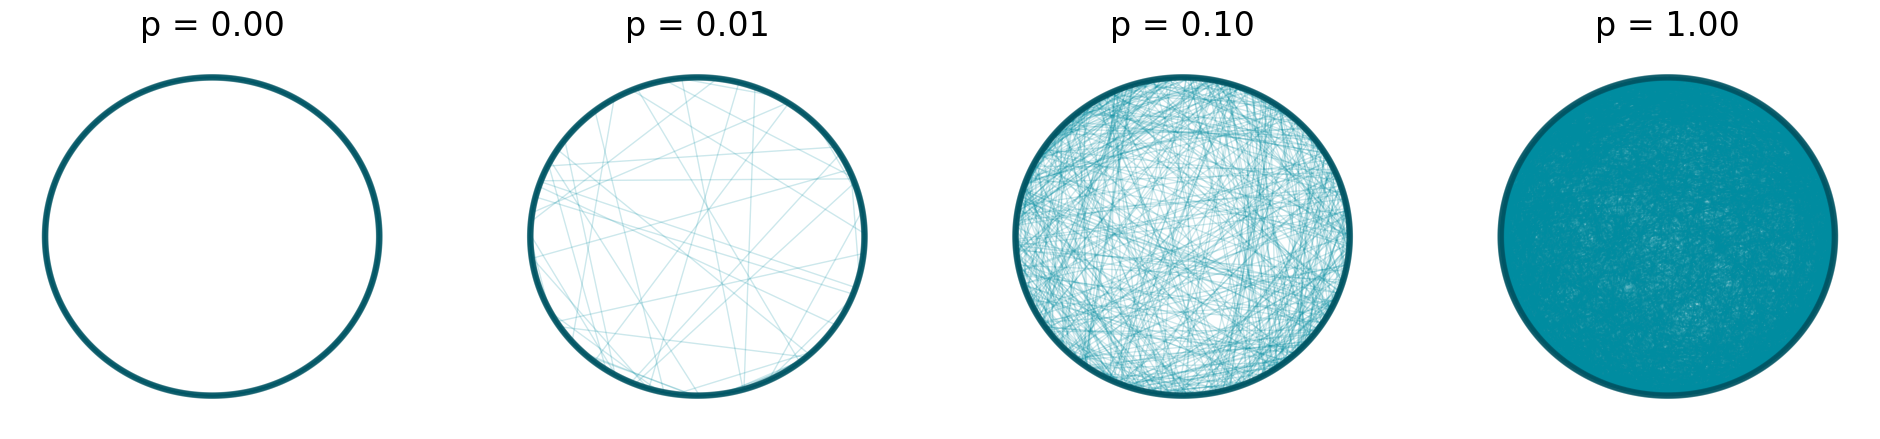

In [5]:
nb_plots = 4

sweep_vals = np.hstack([0.0, np.logspace(-(nb_plots-2), np.log10(max_sweep_val), nb_plots-1)])

fig, axes = plt.subplots(1, nb_plots, figsize = (6*nb_plots, 5))
pos = {i:(np.cos(i*2*np.pi/n), np.sin(i*2*np.pi/n)) for i in range(n)}
for i, sweep_val in enumerate(sweep_vals):
    ax = axes[i]
    G = network_generator(**network_params, **{sweep_param : sweep_val})
    rng.plot_nx(G, ax = ax, pos = pos)
    ax.set_title(f'{sweep_param} = {sweep_val:.2f}', size = 24)

## Calculations

In [6]:
# Calculation parameters
nb_samples = 2**0
new_calculation = False

In [7]:
samples = range(nb_samples)
sweep_vals = np.linspace(start = min_sweep_val, 
                         stop = max_sweep_val, 
                         num = nb_sweep_vals).round(6)

total = nb_samples * nb_sweep_vals
pbar = tqdm(product(sweep_vals, samples), total = total)

data_dict = json_to_dictofdictoflist(fname_pdgms, 
                                     new = new_calculation, 
                                     lambda_key2 = float)
for sweep_val, _ in pbar:
    update_data_dict(data_dict = data_dict,
                     network_generator = network_generator, 
                     network_params = network_params, 
                     sweep_val = sweep_val,
                     sweep_param = sweep_param,
                     point_cloud = False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [25:36<00:00, 46.56s/it]


In [8]:
data_to_json(fname_pdgms, data_dict)

## Plotting

In [9]:
data_dict = json_to_dictofdictoflist(fname_pdgms, lambda_key2=float)

In [10]:
scores_df = (data_dict_to_scores_df(data_dict, key2_name = sweep_param).
                rename({'sweep' : sweep_param}, axis = 1))

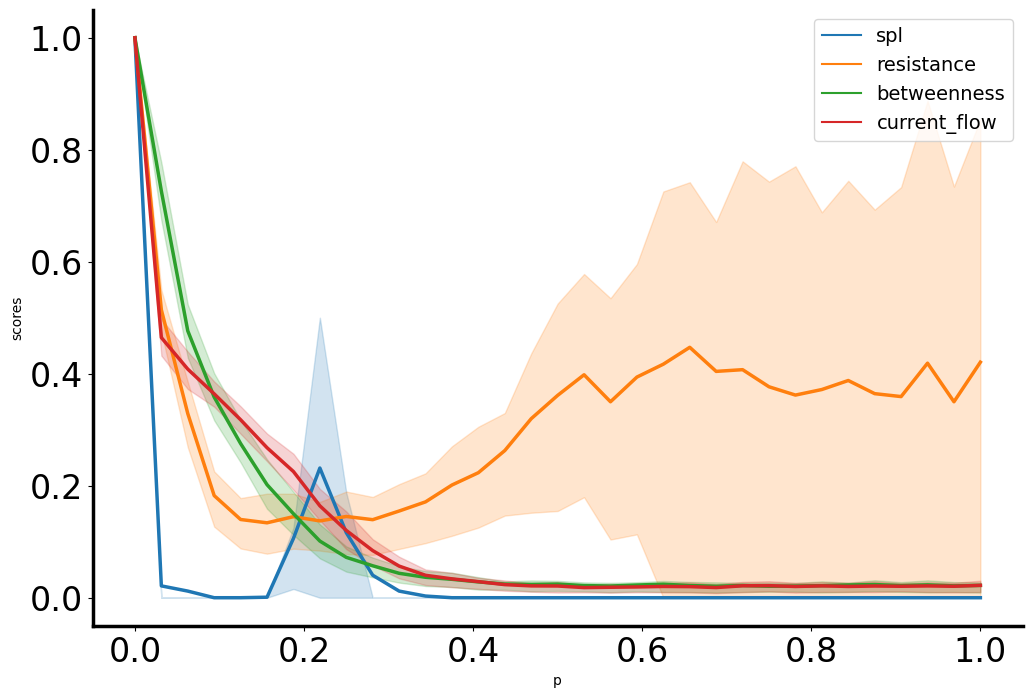

In [11]:
SFig_sum, ax_sum = plt.subplots(figsize = (12,8))

# plot_data = scores_df[scores_df.metric.isin({'X', 'spl', 'resistance'})]
plot_data = scores_df

ax_sum = sns.lineplot(data = plot_data, 
                      x = sweep_param, 
                      y = 'scores', 
                      hue = 'metric', 
                      linewidth = 2.5,
                      errorbar = ('pi', 50),
                      palette = PALETTE[:plot_data.metric.nunique()],
                      ax = ax_sum)

rng.utils.plotting.styling.ax_setup(ax_sum)

leg = ax_sum.legend(fontsize = 14)

SFig_sum.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-WS_N{n}_k{k}-summary.png')
SFig_sum.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-WS_N{n}_k{k}-summary.pdf')

### Panel plot

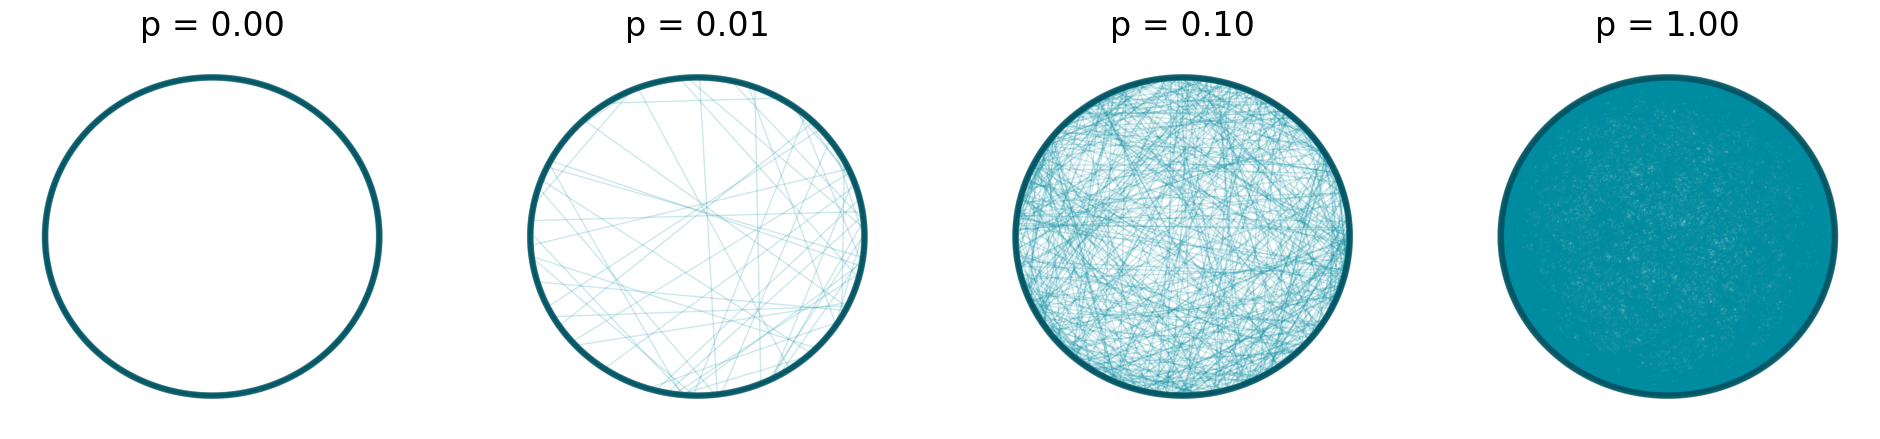

In [12]:
nb_sweep_vals = 4

sweep_vals = [0.0, 0.01, 0.1, 1]

SFig_net, axes_net = plt.subplots(1, nb_sweep_vals, figsize = (6*nb_sweep_vals, 5))
pos = {i:(np.cos(i*2*np.pi/n), np.sin(i*2*np.pi/n)) for i in range(n)}
for i, sweep_val in enumerate(sweep_vals):
    ax = axes_net[i]
    
    G = network_generator(**network_params, **{sweep_param : sweep_val})
    rng.plot_nx(G, ax = ax, pos = pos)
    ax.set_title(f'{sweep_param} = {sweep_val:.2f}', size = 24)
    
SFig_net.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-WS_N{n}_k{k}-networks.png')
SFig_net.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-WS_N{n}_k{k}-networks.pdf')

In [13]:
pbar = tqdm(sweep_vals, total = nb_sweep_vals)

data_dict = json_to_dictofdictoflist('', 
                                     new = True, 
                                     lambda_key2 = float)
for sweep_val in pbar:
    update_data_dict(data_dict = data_dict,
                     network_generator = network_generator, 
                     network_params = network_params, 
                     sweep_val = sweep_val,
                     sweep_param = sweep_param,
                     point_cloud = False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:31<00:00, 67.83s/it]


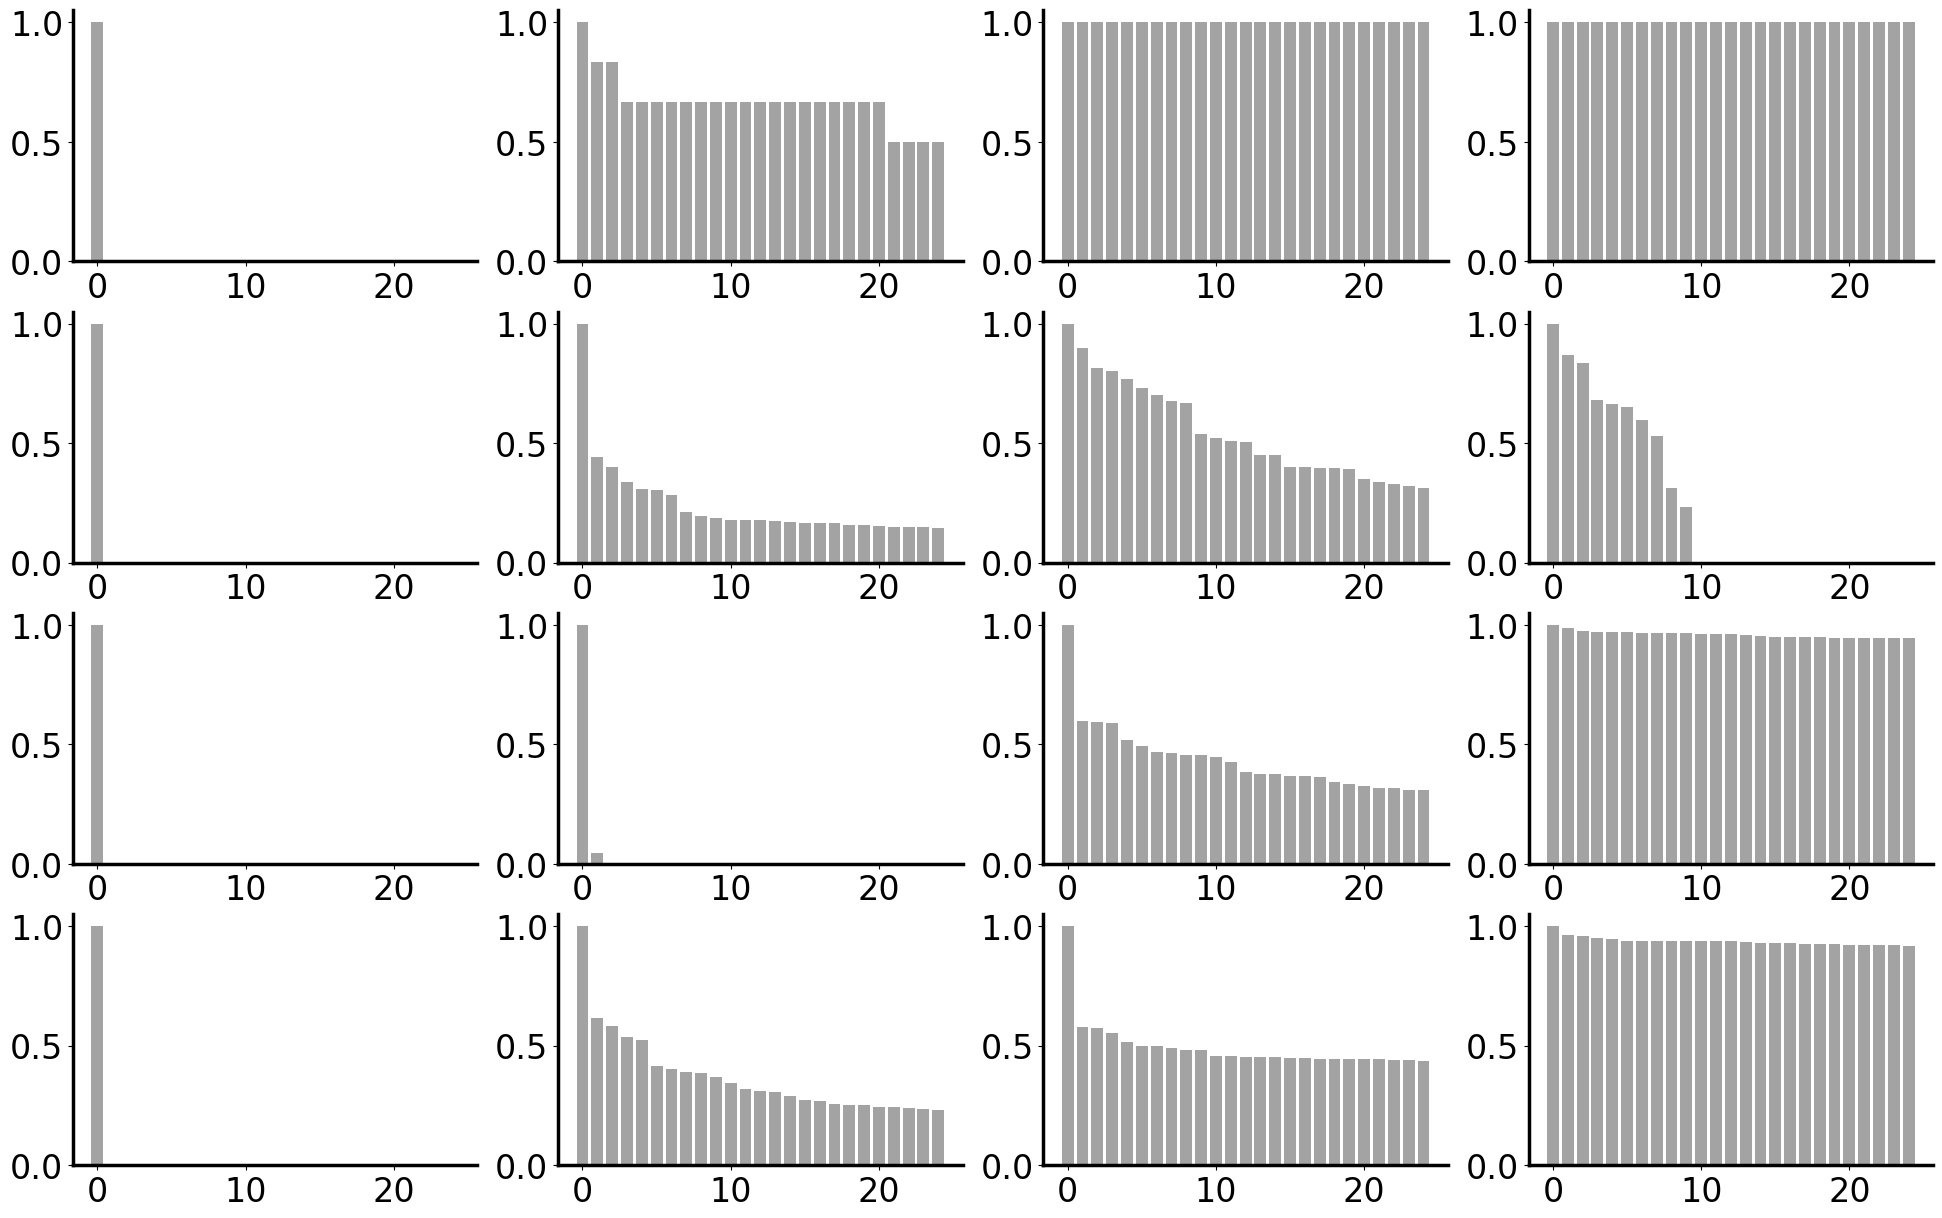

In [14]:
SFig_seq, axes_seq = plt.subplots(len(METRICS), nb_sweep_vals, figsize = (6*nb_sweep_vals, 15))
for (i, sweep_val), (j, metric) in product(enumerate(sweep_vals), enumerate(METRICS)):
    ax = axes_seq[j,i]
    pdgm = data_dict[metric][sweep_val][0].trimmed(25)
    rng.plot_seq(pdgm, ax = ax)

SFig_seq.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-WS_N{n}_k{k}-persistent_sequences.png')
SFig_seq.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-WS_N{n}_k{k}-persistent_sequences.pdf')

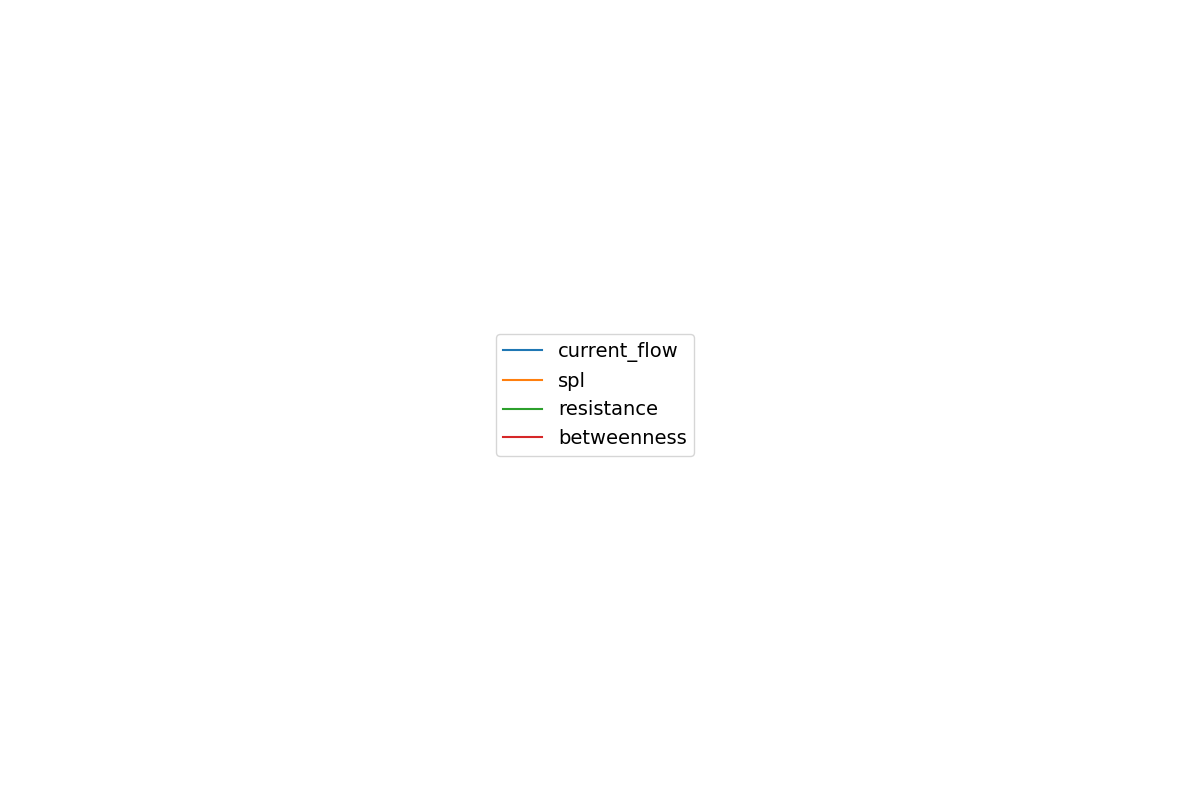

In [15]:
SFig_leg, ax_leg = plt.subplots(figsize = (12,8))

for metric in ['current_flow', 'spl', 'resistance', 'betweenness']:
    ax_leg.plot([],[],label = metric)

ax_leg.set_axis_off()
leg = ax_leg.legend(fontsize = 14, loc = 'center')
SFig_leg.tight_layout()
    
SFig_leg.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-WS_N{n}_k{k}-legend.png')
SFig_leg.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-WS_N{n}_k{k}-legend.pdf')

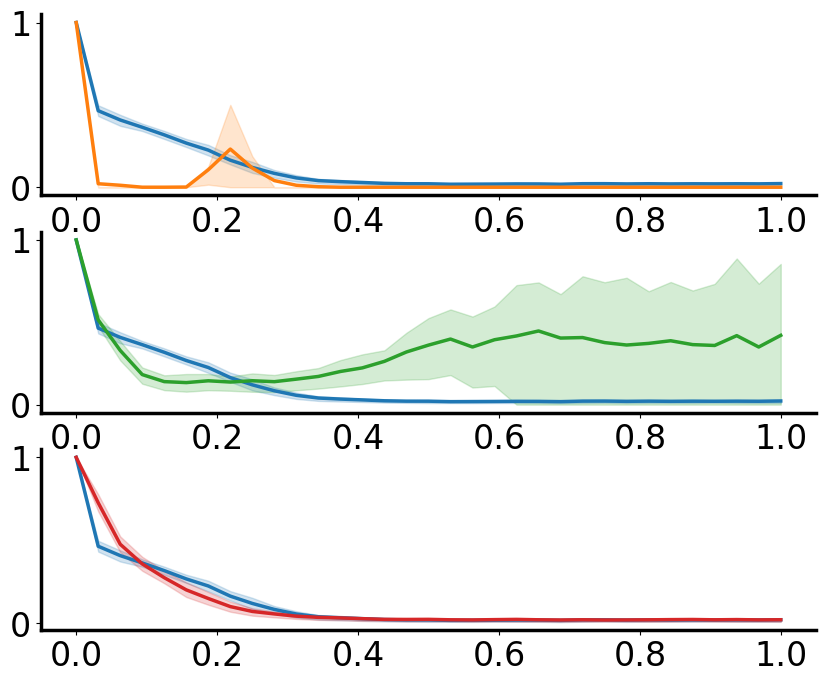

In [16]:
SFig_score, axes_score = plt.subplots(len(METRICS) - 1, figsize = (10,8))

for i, metric in enumerate(METRICS[:-1]):
    curr_plot_data = plot_data[plot_data.metric.isin({'current_flow', metric})].copy()
    curr_plot_data.order = 2
    curr_plot_data.loc[curr_plot_data.metric == 'current_flow', 'order'] = 1
    curr_plot_data = curr_plot_data.sort_values('order')
    ax = axes_score[i]
    ax = sns.lineplot(data = curr_plot_data, 
                      x = sweep_param, 
                      y = 'scores', 
                      hue = 'metric', 
                      linewidth = 2.5,
                      errorbar = ('pi', 50),
                      palette = [PALETTE[0], PALETTE[i+1]],
                      ax = ax)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend([], [], frameon = False)
    rng.utils.plotting.styling.ax_setup(ax)
    
SFig_score.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-WS_N{n}_k{k}-score_curves.png')
SFig_score.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-WS_N{n}_k{k}-score_curves.pdf')

---

# Extending Cylinder Example

## Set Network Parameters

In [17]:
# Network parameters
n = 1000
k = 10

sweep_param = 'height'
nb_sweep_vals = 2**5 + 1
min_sweep_val = 0
max_sweep_val = 10

network_generator = knn_cylinder
network_params = {'n':n, 'k':k}

fname_pdgms = Path(DIRNAME_DATA / 'results' / f'pdgms-extending_cylinder-KNN-n{n}_k{k}.json')

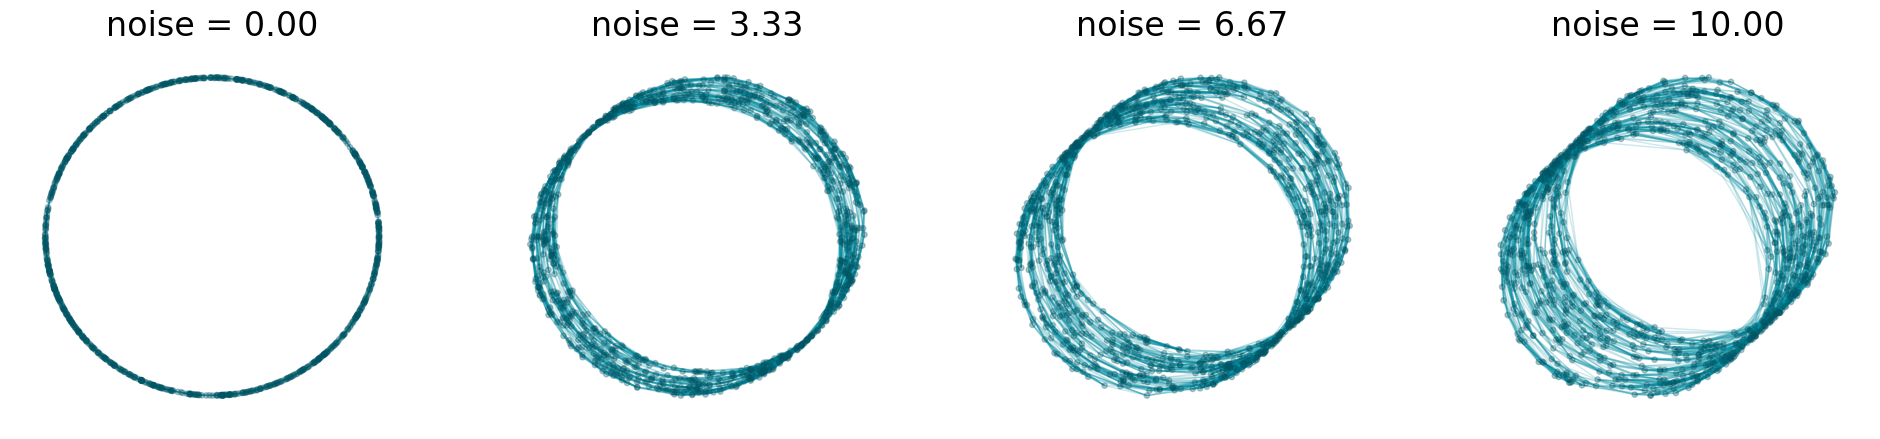

In [18]:
nb_plots = 4

sweep_vals = np.linspace(min_sweep_val, max_sweep_val, nb_plots)

fig, axes = plt.subplots(1, nb_plots, figsize = (6*nb_plots, 5))
for i, sweep_val in enumerate(sweep_vals):
    ax = axes[i]
    G, X = network_generator(**network_params, **{sweep_param : sweep_val})
    pos = dict(enumerate([(a+c/20, b+c/20) for (a,b,c) in X]))
    rng.plot_nx(G, pos = pos, ax = ax)
    ax.set_title(f'noise = {sweep_val:.2f}', size = 24)

## Calculations

In [19]:
# Calculation parameters
nb_samples = 2**0
new_calculation = False

In [20]:
samples = range(nb_samples)
sweep_vals = np.linspace(start = min_sweep_val, 
                         stop = max_sweep_val, 
                         num = nb_sweep_vals).round(6)

total = nb_samples * nb_sweep_vals
pbar = tqdm(product(sweep_vals, samples), total = total)

data_dict = json_to_dictofdictoflist(fname_pdgms, 
                                     new = new_calculation, 
                                     lambda_key2 = float)
for sweep_val, _ in pbar:
    update_data_dict(data_dict = data_dict,
                 network_generator = network_generator, 
                 network_params = network_params, 
                 sweep_val = sweep_val,
                 sweep_param = sweep_param,
                 point_cloud = True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [09:07<00:00, 16.61s/it]


In [21]:
data_to_json(fname_pdgms, data_dict)

## Plotting

In [22]:
data_dict = json_to_dictofdictoflist(fname_pdgms, lambda_key2 = float)

In [23]:
scores_df = (data_dict_to_scores_df(data_dict, key2_name = sweep_param).
                rename({'sweep' : sweep_param}, axis = 1))

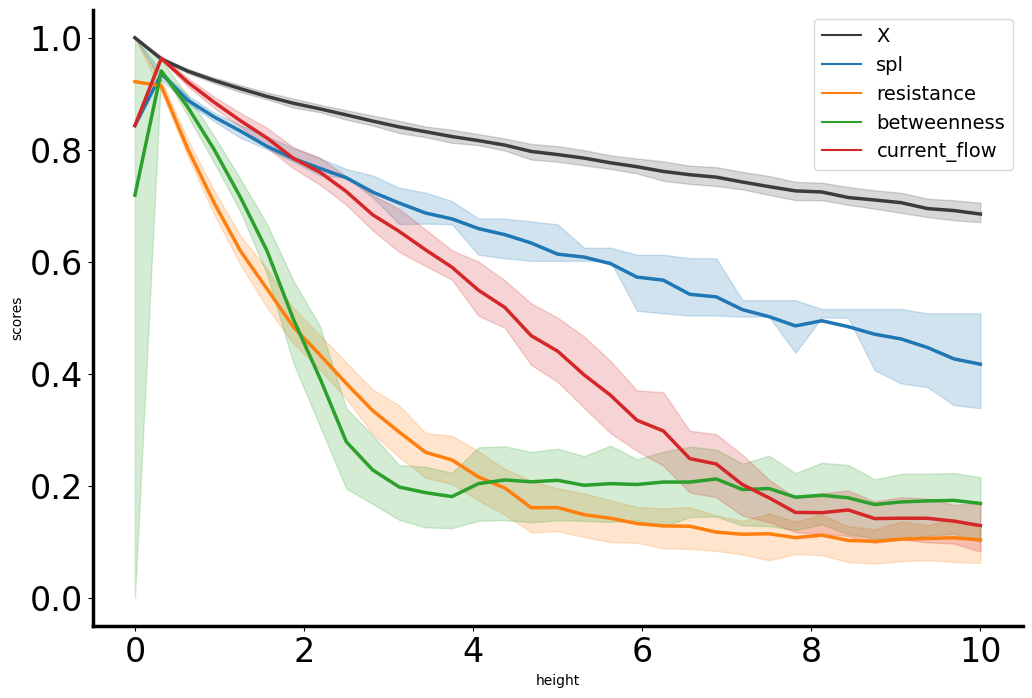

In [24]:
SFig_sum, ax_sum = plt.subplots(figsize = (12,8))

# plot_data = scores_df[scores_df.metric.isin({'X', 'spl', 'resistance'})]
plot_data = scores_df

ax_sum = sns.lineplot(data = plot_data, 
                      x = sweep_param, 
                      y = 'scores', 
                      hue = 'metric', 
                      linewidth = 2.5,
                      errorbar = ('pi', 50),
                      palette = [COLOR_X] + PALETTE,
                      ax = ax_sum)

rng.utils.plotting.styling.ax_setup(ax_sum)

leg = ax_sum.legend(fontsize = 14)

SFig_sum.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-summary.png')
SFig_sum.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-summary.pdf')

### Panel plots

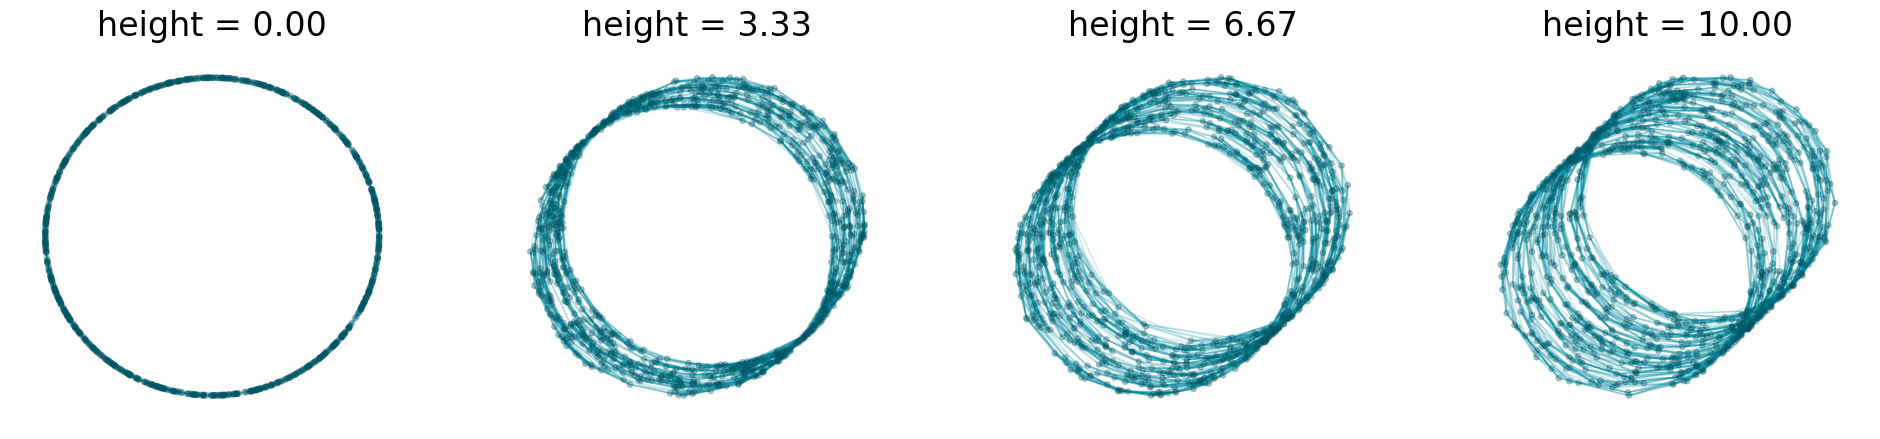

In [25]:
nb_sweep_vals = 4

sweep_vals = np.linspace(min_sweep_val, max_sweep_val, nb_sweep_vals)

SFig_net, axes_net = plt.subplots(1, nb_plots, figsize = (6*nb_sweep_vals, 5))
for i, sweep_val in enumerate(sweep_vals):
    ax = axes_net[i]
    G, X = network_generator(**network_params, **{sweep_param : sweep_val})
    pos = dict(enumerate([(a+c/15, b+c/15) for (a,b,c) in X]))
    rng.plot_nx(G, pos = pos, ax = ax)
    ax.set_title(f'height = {sweep_val:.2f}', size = 24)

    
SFig_net.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-networks.png')
SFig_net.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-networks.pdf')

In [26]:
pbar = tqdm(sweep_vals, total = nb_sweep_vals)

data_dict = json_to_dictofdictoflist('', 
                                     new = True, 
                                     lambda_key2 = float)
for sweep_val in pbar:
    update_data_dict(data_dict = data_dict,
                     network_generator = network_generator, 
                     network_params = network_params, 
                     sweep_val = sweep_val,
                     sweep_param = sweep_param,
                     point_cloud = True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:06<00:00, 16.51s/it]


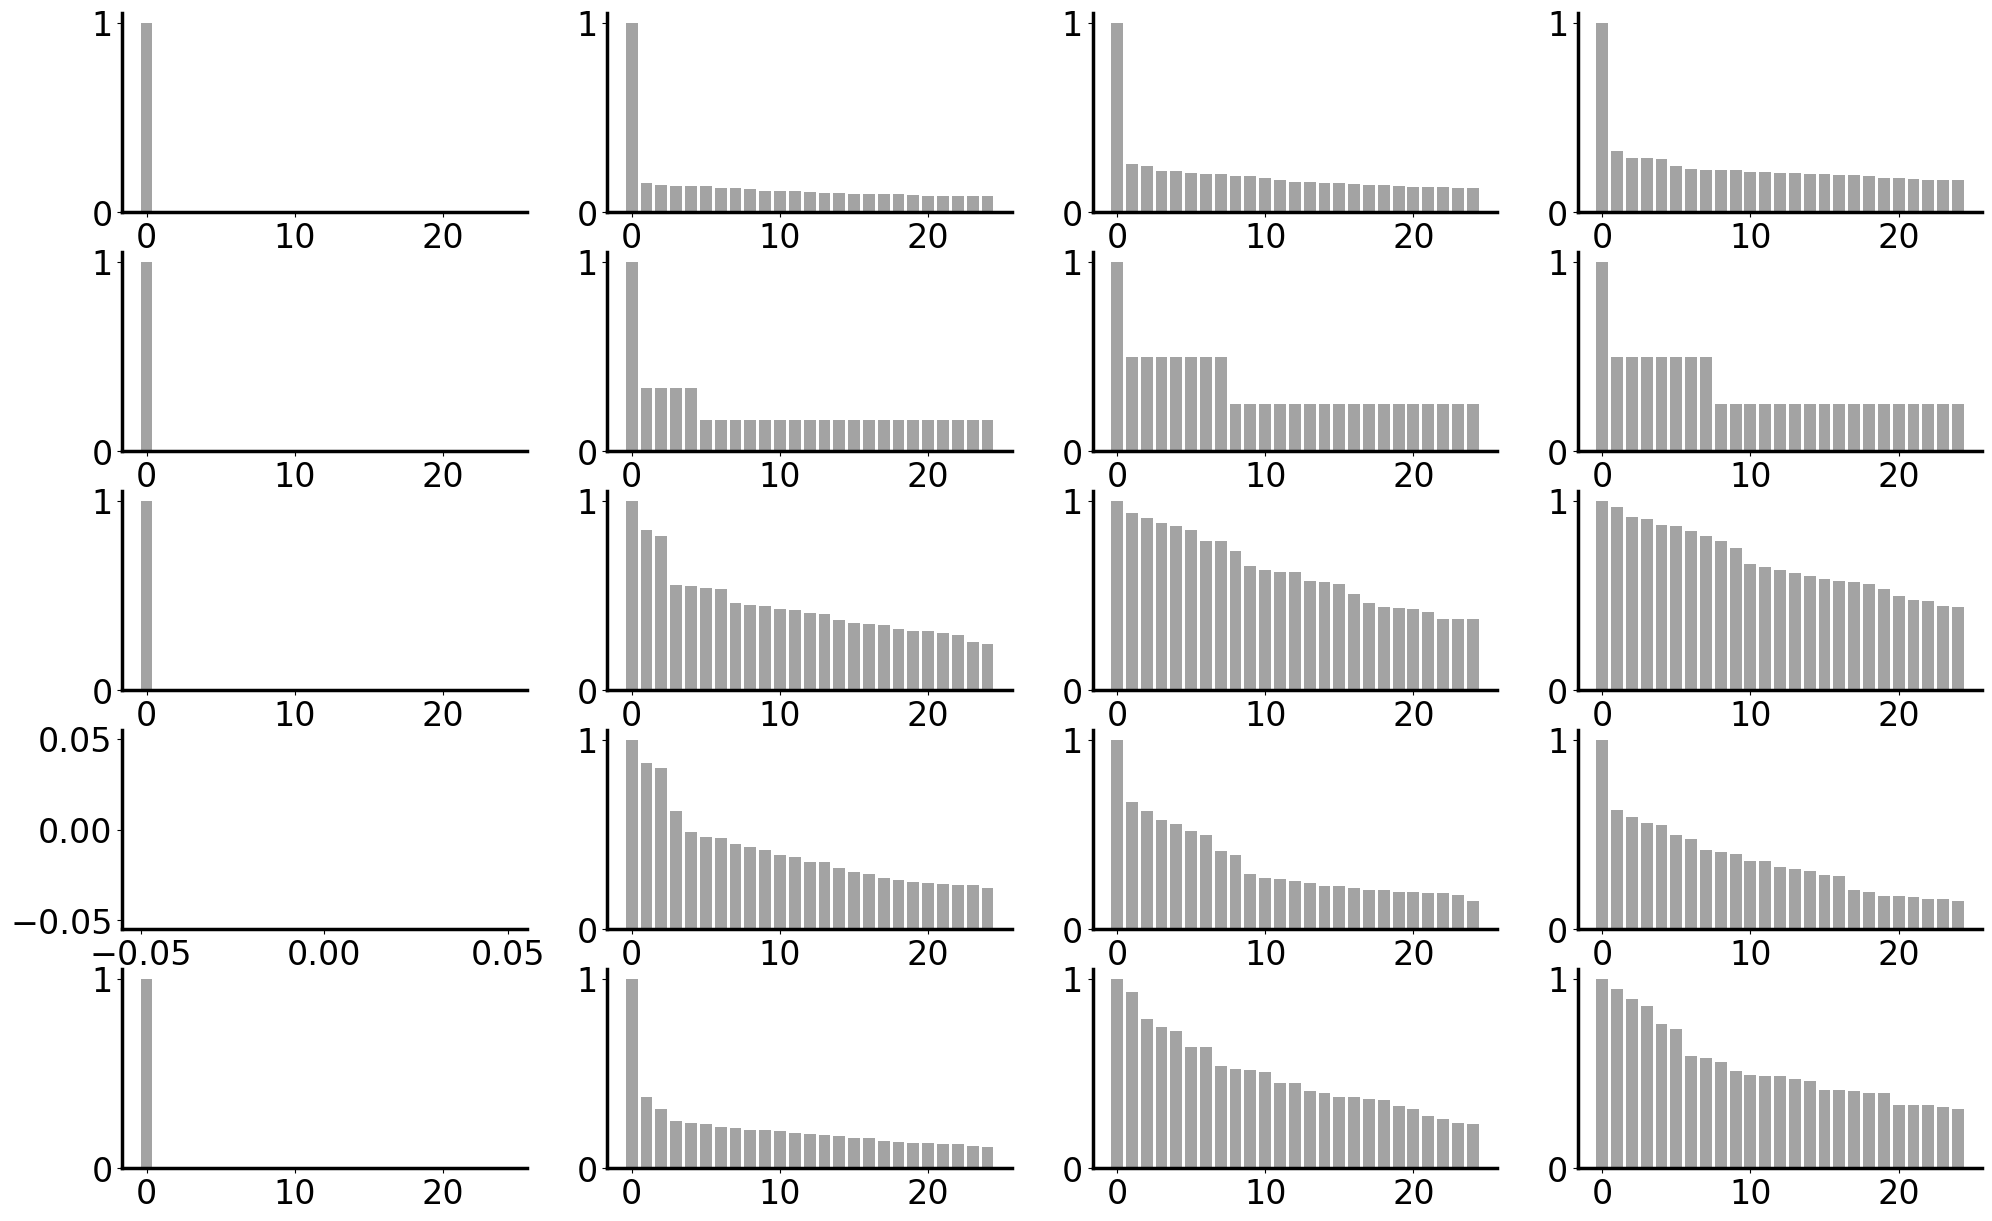

In [27]:
SFig_seq, axes_seq = plt.subplots(len(METRICS)+1, nb_sweep_vals, figsize = (6*nb_sweep_vals, 15))
for (i, sweep_val), (j, metric) in product(enumerate(sweep_vals), enumerate(['X'] + METRICS)):
    ax = axes_seq[j,i]
    pdgm = data_dict[metric][sweep_val][0].trimmed(25)
    rng.plot_seq(pdgm, ax = ax)

SFig_seq.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-persistent_sequences.png')
SFig_seq.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-persistent_sequences.pdf')

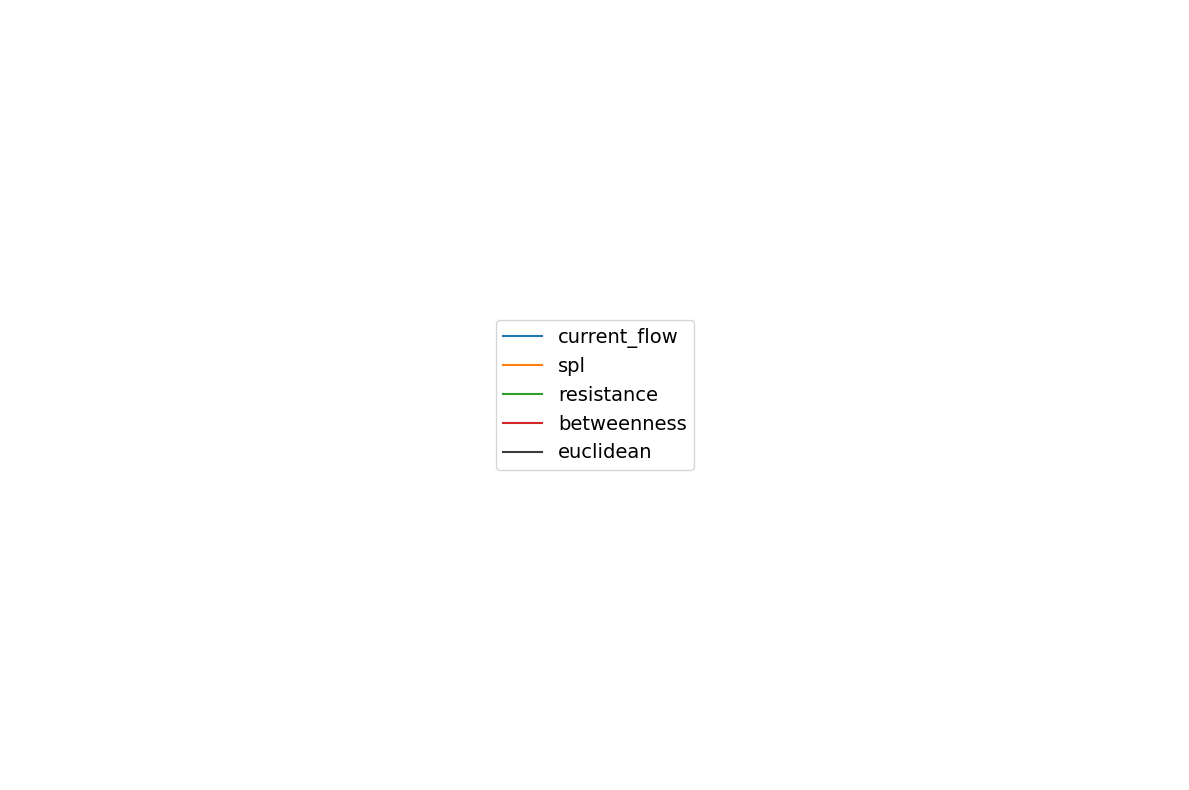

In [28]:
SFig_leg, ax_leg = plt.subplots(figsize = (12,8))

for metric in ['current_flow', 'spl', 'resistance', 'betweenness']:
    ax_leg.plot([],[],label = metric)
ax_leg.plot([],[],label = 'euclidean', color = COLOR_X)
ax_leg.set_axis_off()
leg = ax_leg.legend(fontsize = 14, loc = 'center')
SFig_leg.tight_layout()

    
SFig_leg.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-legend.png')
SFig_leg.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-legend.pdf')

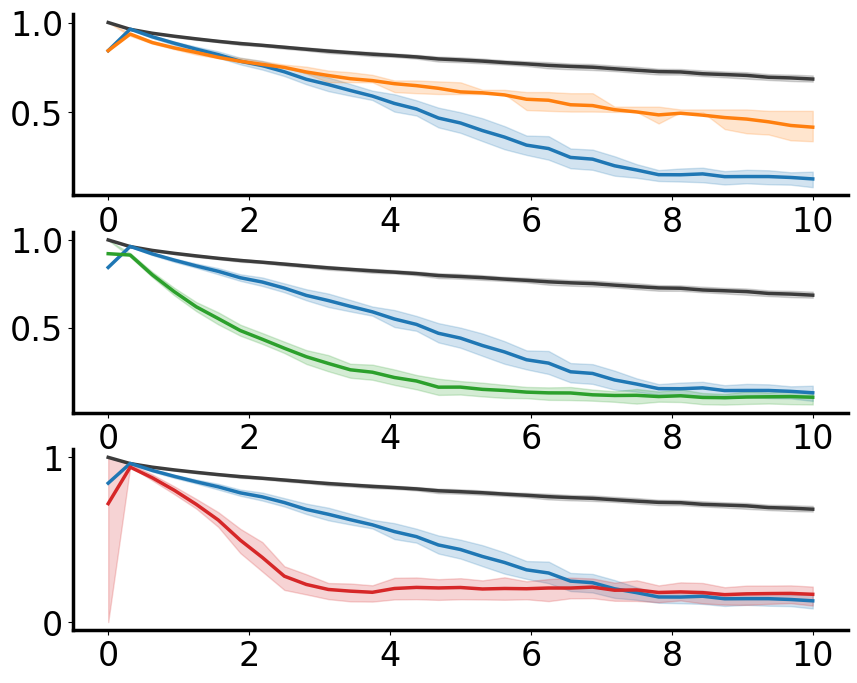

In [29]:
SFig_score, axes_score = plt.subplots(len(METRICS) - 1, figsize = (10,8))

for i, metric in enumerate(METRICS[:-1]):
    curr_plot_data = plot_data[plot_data.metric.isin({'X', 'current_flow', metric})].copy()
    curr_plot_data.order = 3
    curr_plot_data.loc[curr_plot_data.metric == 'current_flow', 'order'] = 2
    curr_plot_data.loc[curr_plot_data.metric == 'X', 'order'] = 1
    curr_plot_data = curr_plot_data.sort_values('order')
    ax = axes_score[i]
    ax = sns.lineplot(data = curr_plot_data, 
                      x = sweep_param, 
                      y = 'scores', 
                      hue = 'metric', 
                      linewidth = 2.5,
                      errorbar = ('pi', 50),
                      palette = [COLOR_X, PALETTE[0], PALETTE[i+1]],
                      ax = ax)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend([], [], frameon = False)
    rng.utils.plotting.styling.ax_setup(ax)
    
SFig_score.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-score_curves.png')
SFig_score.savefig(DIRNAME_DATA / 'plots'/ f'SFig-metric_analysis-extending_cylinder-KNN-n{n}_k{k}-score_curves.pdf')